In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/prepared_data.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,Token_Summary,Token_Text,reviews_length,avg_word_length,reviews_per_user,avg_product_score,is_positive_score,n_marks,n_caps,n_punct
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,"['good', 'quality', 'dog', 'food']","['buy', 'several', 'vitality', 'can', 'dog', '...",232,1.0,1,5.0,1,0,1,3
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,['advertise'],"['product', 'arrive', 'label', 'jumbo', 'salt'...",163,1.0,1,1.0,0,0,0,7
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,...,"['delight', 'say']","['confection', 'around', 'century', 'light', '...",432,1.0,3,4.0,1,0,2,18
3,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",...,"['fast', 'easy', 'organic']","['speed', 'wholesome', 'goodness', 'annie', 'n...",234,1.0,3,4.0,1,1,2,15
4,320680,B000CQ26E0,A2RNYW2HIQBGSM,Carlos Alvarez,3,3,5,1238371200,"Tastes great, easy to make",These are really good. You do need to add jus...,...,"['taste', 'great', 'easy', 'make']","['good', 'need', 'add', 'water', 'recommend', ...",167,1.0,45,4.0,1,0,0,6


## Introduction 
Many e-commerce sites offer users the opportunity to post their own reviews of products they have purchased. These reviews contain a wealth of information about users' experiences with a company's products, and other users may read these reviews when considering making a purchase. But because reviews consist mainly of user-generated text, it can be difficult for a business to extract insights from thousands of them

On some e-commerce sites, users have the opportunity to rate another user's product review as "helpful" or not, and analyzing these "helpful" reviews can help a business understand what its customers want to know about its products before buying. At the very least, being able to identify and promote potentially "helpful" reviews, even without directly analyzing their contents, could help potential customers get the information they need sooner.


## Initial exploration and cleaning
### Check for duplicates
With such a large dataset, one of my first concerns is whether it contains many duplicate entries. In particular, I am concerned about:

* true duplicate entries, i.e., the exact same review of the same product by the same person, and
* "spam" entries, i.e., the exact same text posted to multiple products

In [4]:
df.ProductId.value_counts()

B007JFMH8M    913
B002QWHJOU    629
B002QWP89S    629
B0026RQTGE    629
B002QWP8H0    629
             ... 
B007VJ1W0K      1
B006SF5T7U      1
B006SF5RZE      1
B006SF5RYK      1
B001LR2CU2      1
Name: ProductId, Length: 74258, dtype: int64

It makes sense that there would be multiple reviews of some products, so these value counts are not unexpected.

In [5]:
df.UserId.value_counts()

A3OXHLG6DIBRW8    439
A1YUL9PCJR3JTY    410
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
AKNEZCDOFKYV2       1
A2KL86YQ3G9XRS      1
A3N8T534UDMJRL      1
A3RA2S25DDQABY      1
A3LGQPJCZVL9UC      1
Name: UserId, Length: 256047, dtype: int64

It's also reasonable that some reviewers write many reviews, but 439 reviews is quite a lot! Let's see how many times the same combinations of products and reviewers are repeated.

In [6]:
dups = df.duplicated(subset=['ProductId', 'UserId'])
dups.sum()

6202

So it seems there may be 6202 times where the same user reviewed the same product more than once. Let's try to inspect some examples and see if we can figure out what's going on

In [7]:
dups[dups == True].iloc[:5]

466    True
472    True
538    True
544    True
610    True
dtype: bool

In [8]:
df.iloc[466]

Id                                                                   135684
ProductId                                                        B003THML30
UserId                                                        AHWQNLEQRFUYN
ProfileName                                   Colleen P. Perry "Peanutfish"
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    1
Score                                                                     5
Time                                                             1288310400
Summary                                                          Excellent!
Text                      I love these bars.  They are lighter and crisp...
Cleaned_Summary                                                   excellent
Cleaned_Text              love these bars they are lighter and crisper t...
Token_Summary                                                 ['excellent']
Token_Text  

In [9]:
scrapper = df[df.UserId == 'AHWQNLEQRFUYN']
scrapper.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,reviews_length,avg_word_length,reviews_per_user,avg_product_score,is_positive_score,n_marks,n_caps,n_punct
count,16.000000,16.000000,16.000000,16.0,1.600000e+01,16.000000,16.0,16.0,1.600000e+01,16.0,16.0,16.000000,16.000000
mean,349987.750000,1.500000,1.500000,5.0,1.288310e+09,161.000000,1.0,16.0,3.736111e+00,1.0,0.0,0.500000,4.000000
std,125923.438165,0.516398,0.516398,0.0,0.000000e+00,13.426342,0.0,0.0,1.375960e-15,0.0,0.0,0.516398,1.032796
min,135677.000000,1.000000,1.000000,5.0,1.288310e+09,148.000000,1.0,16.0,3.736111e+00,1.0,0.0,0.000000,3.000000
25%,289652.750000,1.000000,1.000000,5.0,1.288310e+09,148.000000,1.0,16.0,3.736111e+00,1.0,0.0,0.000000,3.000000
50%,338481.000000,1.500000,1.500000,5.0,1.288310e+09,161.000000,1.0,16.0,3.736111e+00,1.0,0.0,0.500000,4.000000
75%,405801.000000,2.000000,2.000000,5.0,1.288310e+09,174.000000,1.0,16.0,3.736111e+00,1.0,0.0,1.000000,5.000000
max,558654.000000,2.000000,2.000000,5.0,1.288310e+09,174.000000,1.0,16.0,3.736111e+00,1.0,0.0,1.000000,5.000000


"Scrapper" seems to have very positive opinions of the products she reviews, although she doesn't score a lot of "helpful" ratings.

How many duplicate reviews has she produced?

In [10]:
scrapper.ProductId.value_counts()

B003THML30    2
B004YWHTBS    2
B003WLC4VC    2
B003THQKXM    2
B003NZHOQ2    2
B005LXGGH2    2
B003THTKZC    2
B003UE2X2G    2
Name: ProductId, dtype: int64

It looks like she reviewed the first 8 products twice each. That's weird, but not that weird; maybe she just wanted to review those products more than once

What about the reviews ?

In [11]:
scrapper.Text.value_counts()

These are perfect for when you'd like to have that chocolate chip cookie and you know you shouldn't.  Its crunch, crispy with just the right amount of chocolate chips to satisfy your craving.    8
I love these bars.  They are lighter and crisper than the nature valley brand.  Being that they have protein as well they make it a better choice to stave off hunger.                             8
Name: Text, dtype: int64

finding all duplicate review texts 

In [12]:
df.Text.value_counts()[:2]

Diamond Almonds<br />Almonds are a good source of magnesium. One ounce contain approximately 20% of the RDA for an adult recommended dietary allowance (RDA)<br />Recommended Dietary Allowance (RDA) the amounts of selected nutrients considered adequate to meet the known nutrient needs of healthy people. The RDA is based on scientific knowledge and has been presented by a committee of the Food and Nutrition Board (FNB) of the National Academy of Sciences (NAS). The Canadian equivalent is the Recommended Nutrient Intakes. RDA is generally accepted throughout the world as a valid source of information. At least 40 different nations have as well as organizations have published standards similar to the RDA.<br /><br />Magnesium is the fourth most abundant mineral in the body and is essential to good health. Approximately 50% of total body magnesium is found in bone. The other half is found predominantly inside cells of body tissues and organs. Only 1% of magnesium is found in blood, but the 

The first review in this printout occurs 40 times in the dataset
I think it would be safe to consider any non-unique review text as spam and remove all but the first instance from the dataset. How many spam reviews are there?

In [13]:
dupe_texts = df.duplicated(subset=['Text'])
dupe_texts.sum()

173437

almost 174,000 of the reviews texts are non-unique! 
they must go 

In [14]:
len(df)

566961

In [4]:
data_no_dupe_text = df.drop_duplicates(subset=['Text'])

In [ ]:
len(data_no_dupe_text)

393524

In [ ]:
data_no_dupe_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393524 entries, 0 to 566960
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      393524 non-null  int64  
 1   ProductId               393524 non-null  object 
 2   UserId                  393524 non-null  object 
 3   ProfileName             393524 non-null  object 
 4   HelpfulnessNumerator    393524 non-null  int64  
 5   HelpfulnessDenominator  393524 non-null  int64  
 6   Score                   393524 non-null  int64  
 7   Time                    393524 non-null  int64  
 8   Summary                 393524 non-null  object 
 9   Text                    393524 non-null  object 
 10  Cleaned_Summary         392330 non-null  object 
 11  Cleaned_Text            393521 non-null  object 
 12  Token_Summary           393524 non-null  object 
 13  Token_Text              393524 non-null  object 
 14  reviews_length      

## Save and Copy the Data for Modeling

In [5]:
data = data_no_dupe_text.copy()

In [6]:
data.isna().sum()

Id                           0
ProductId                    0
UserId                       0
ProfileName                  0
HelpfulnessNumerator         0
HelpfulnessDenominator       0
Score                        0
Time                         0
Summary                      0
Text                         0
Cleaned_Summary           1194
Cleaned_Text                 3
Token_Summary                0
Token_Text                   0
reviews_length               0
avg_word_length              0
reviews_per_user             0
avg_product_score            0
is_positive_score            0
n_marks                      0
n_caps                       0
n_punct                      0
dtype: int64

In [7]:
data.dropna(subset=['Cleaned_Text'], inplace=True)
data.isna().sum()

Id                           0
ProductId                    0
UserId                       0
ProfileName                  0
HelpfulnessNumerator         0
HelpfulnessDenominator       0
Score                        0
Time                         0
Summary                      0
Text                         0
Cleaned_Summary           1192
Cleaned_Text                 0
Token_Summary                0
Token_Text                   0
reviews_length               0
avg_word_length              0
reviews_per_user             0
avg_product_score            0
is_positive_score            0
n_marks                      0
n_caps                       0
n_punct                      0
dtype: int64

### Creating the difference feature 
which is measuring the difference between the total numbers of the votes and the number of the upvotes.

In [8]:
data['difference'] = df.HelpfulnessDenominator - df.HelpfulnessNumerator

In [9]:
data.difference.describe()

count    393521.000000
mean          0.470509
std           1.906014
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         140.000000
Name: difference, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


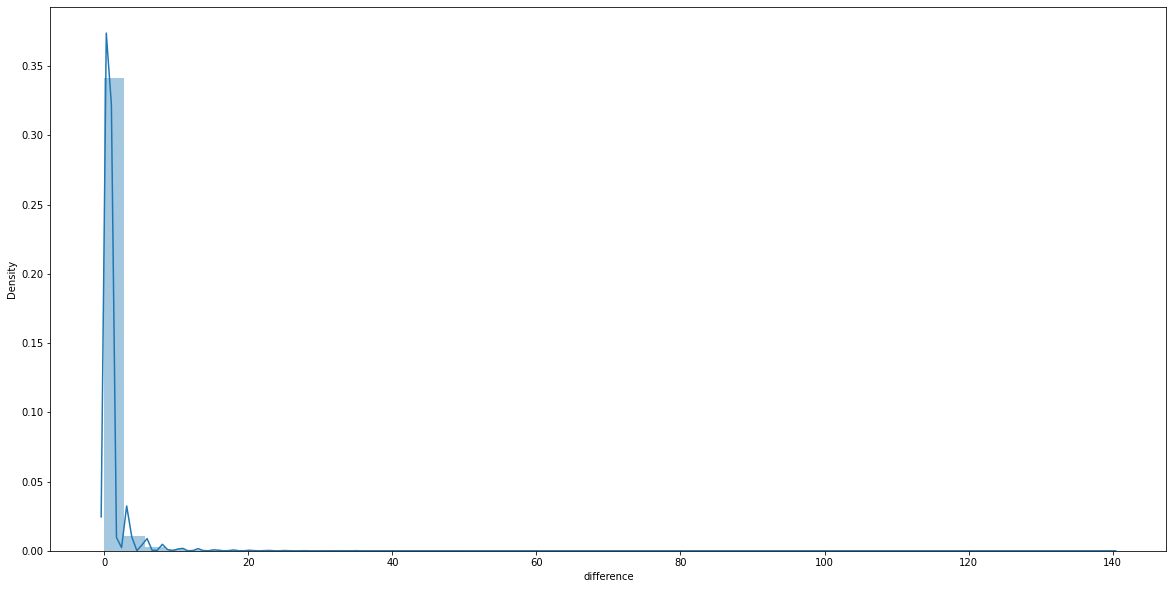

In [10]:
plt.figure(figsize=(20, 10))
sns.distplot(data.difference)

In [11]:
data.difference.value_counts()

0     315654
1      46501
2      13813
3       6011
4       3326
       ...  
90         1
77         1
70         1
78         1
84         1
Name: difference, Length: 87, dtype: int64

In [23]:
len(data)

393521

In [12]:
data_op = data.copy()

Choosing the reviews which have been indicated before as helpful or not 

In [13]:
data_op = data_op[data_op.HelpfulnessDenominator != 0]

In [14]:
data_op.difference.value_counts()

0     131193
1      46501
2      13813
3       6011
4       3326
       ...  
90         1
77         1
70         1
78         1
84         1
Name: difference, Length: 87, dtype: int64

In [15]:
data_op['helpful'] = data_op.difference

In [ ]:
data_op.helpful[data_op.difference <= 1] = 1
data_op.helpful[data_op.difference > 1] = 0

In [17]:
data_op.helpful.value_counts()

1    177694
0     31366
Name: helpful, dtype: int64

So after studying multiple scenarios for this task, we can't take any action or decision for granted, So we have splited the difference as if the difference is less than or equal to one then the review is definitely helpful, otherwise we can't tell that the review is definitely unhelpful instead we can say that it might be helpful, or we can suggest them to the new users. 

## Preparing for the Model 

In [18]:
X = data_op.Cleaned_Text
y = data_op.helpful 

## Vectorization 

In [19]:
count_vec = CountVectorizer()
X_count = count_vec.fit_transform(X)

In [20]:
tf_transformer = TfidfTransformer(use_idf=False)
X_tf = tf_transformer.fit_transform(X_count)

## Normalization 

In [21]:
sc = StandardScaler(with_mean=False)
X_tf= sc.fit_transform(X_tf)

## Splitting the Data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, train_size=0.75)

print(X_train.shape)
print(X_test.shape)

(156795, 87863)
(52265, 87863)


## Naive Bayes

In [23]:
# Base Model
clf = MultinomialNB()

clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(train_acc)
print(test_acc)

0.8695494116521573
0.7190088969673778


## SGD Classifier 

In [24]:
clf = SGDClassifier(class_weight='balanced')

clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(train_acc)
print(test_acc)

0.8499505724034567
0.6877642781976466


In [25]:
confusion_matrix(y_test, test_preds)

array([[ 3675,  4228],
       [12091, 32271]])

In [38]:
recall_score(y_test, test_preds)

0.7098419976176028

In [40]:
precision_score(y_test, test_preds)

0.8870134247037016

## Random Forest 

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(train_acc)
print(test_acc)

0.9998724449121464
0.8507222806849708


In [ ]:
confusion_matrix(y_test, test_preds)

array([[   59,  7776],
       [   26, 44404]])

## Logistic Regression

In [34]:
lr = LogisticRegression(C=0.8, max_iter=500)
lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(train_acc)
print(test_acc)

0.9357505022481585
0.7913134985171721


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [56]:
lr = LogisticRegression(C=0.1, max_iter=500)
lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(train_acc)
print(test_acc)

0.9356548359322683
0.7933033578876878


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
